# Import all required libraries

In [15]:
import os
import cv2
import time
import joblib
import logging

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.feature import hog
from datetime import datetime
from dataclasses import dataclass
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imutils.object_detection import non_max_suppression
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

# Integrate all hyperparameters into 'config' for unified management in later use

In [16]:
@dataclass
class SVMConfig:
    # Dataset and input image dimensions
    train_path: str = r"C:\Users\jixia\Desktop\343434\DataSet\train"                    # Training dataset path
    test_path: str = r"C:\Users\jixia\Desktop\343434\DataSet\test"                      # Testing dataset path
    image_size: tuple = (32, 96)                                                        # Input image size (width, height)
    save_results: str = r".\model"                                                      # Path to save trained models and results

    # Test module settings (only supports testing on images)
    load_models: str = r"C:\Users\jixia\Desktop\343434\hog_svm\model"                   # Path to load trained models
    test_files: str = r"C:\Users\jixia\Desktop\images"                                  # Test image path

    # Sliding window and multi-scale image processing parameters
    step_size: int = 8                                                                  # Step size for sliding window
    window_size: tuple = (32, 96)                                                       # Sliding window size, must match training feature size
    scale: float = 1.2                                                                  # Scaling factor for image pyramid
    min_size: tuple = (64, 128)                                                         # Minimum image size for the pyramid
    dis_thre: float = 1.0                                                               # SVM decision boundary threshold
    nms_threshold: float = 0.5                                                          # Non-Maximum Suppression (NMS) threshold

    # HOG feature extraction hyperparameters
    orientations: int = 9                                                               # Number of gradient orientation bins
    pixels_per_cell: tuple = (8, 8)                                                     # Size of each cell in pixels
    cells_per_block: tuple = (2, 2)                                                     # Number of cells per block
    block_norm: str = "L2-Hys"                                                          # Normalization method
    transform_sqrt: bool = True                                                         # Apply gamma correction
    feature_vector: bool = True                                                         # Flatten HOG features into a 1D vector

    # SVM training hyperparameters
    C: list = (0.1, 1, 10, 100)                                                         # Regularization parameter
    kernel: list = ("linear", "rbf")                                                    # Kernel function types
    gamma: list = ("scale", "auto", 0.001, 0.01, 0.1)                                   # RBF kernel coefficient
    # degree: list = (2, 3, 4, 5)                                                         # Degree of polynomial kernel (if used)
    # coef0: list = (0, 0.1, 0.5, 1)                                                      # Independent term in polynomial/sigmoid kernels
    # shrinking: list = (True, False)                                                     # Whether to use shrinking heuristic
    # class_weight: list = (None, "balanced")                                             # Class weight adjustment
    # max_iter: list = (1000, 3000)                                                       # Maximum number of training iterations

    # Multi-threading parameters
    max_workers: int = 4                                                                # Number of threads for parallel processing

config = SVMConfig()


# Add logging to record intermediate information during each training

In [17]:
logging.basicConfig(
    filename="svm_training.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",  # log format
    datefmt="%Y-%m-%d %H:%M:%S",
)

logging.info("Args:")
for key, value in config.__dict__.items():
    logging.info(f"  {key}: {value}")

# Data Loading Module
# The dataset is organized into training and testing sets, with each set containing positive and negative samples
# 
# Dataset Structure:
# │
# ├── train                # Training dataset
# │   ├── pos              # Positive samples
# │   └── neg              # Negative samples
# │
# └── test                 # Testing dataset
#     ├── pos              # Positive samples
#     └── neg              # Negative samples

In [18]:
# Traverse the directory to load images and resize them to the specified size
def traversal_data(path, image_size):
    images_list = []
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
    return images_list

# Load positive and negative samples from the given directories
def load_dataset(pos_dir, neg_dir, image_size):
    positive =  traversal_data(pos_dir, image_size)
    negative =  traversal_data(neg_dir, image_size)
    return positive, negative

#  load the training and testing sets
train = config.train_path
test = config.test_path

# Print the number of loaded samples for both training and testing sets
train_positive, train_negative = load_dataset(os.path.join(train, 'pos'), os.path.join(train, 'neg'), config.image_size)
test_positive, test_negative = load_dataset(os.path.join(test, 'pos'), os.path.join(test, 'neg'), config.image_size)
logging.info("Loading dataset...")
logging.info(f"Loaded {len(train_positive)} positive samples and {len(train_negative)} negative samples.")
logging.info(f"Loaded {len(test_positive)} positive samples and {len(test_negative)} negative samples.")

# positive: samples containing human bodies; negative: samples without human bodies
# Extract HOG features and generate corresponding labels, stored in X and y respectively, using default HOG parameters

In [19]:
X_train = np.array([hog(im, 
                        orientations = config.orientations,
                        pixels_per_cell = config.pixels_per_cell,
                        cells_per_block = config.cells_per_block,
                        block_norm = config.block_norm,
                        transform_sqrt = config.transform_sqrt,
                        feature_vector = config.feature_vector) for im in chain(train_positive, train_negative)])
y_train = np.hstack([np.ones(len(train_positive)), np.zeros(len(train_negative))])
X_test = np.array([hog(im,
                       orientations = config.orientations,
                        pixels_per_cell = config.pixels_per_cell,
                        cells_per_block = config.cells_per_block,
                        block_norm = config.block_norm,
                        transform_sqrt = config.transform_sqrt,
                        feature_vector = config.feature_vector) for im in chain(test_positive, test_negative)])
y_test = np.hstack([np.ones(len(test_positive)), np.zeros(len(test_negative))])

# Data standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

current_time = datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
scale_model = os.path.join(config.save_results, "scale_model_" + formatted_time + ".pkl")
joblib.dump(scaler, scale_model)
logging.info("Scale model has been saved to: {}".format(scale_model))

# Train Model

In [20]:
# Setup parameters
param_grid = {
    "C": config.C,
    "kernel": config.kernel,
    "gamma": config.gamma,
    # "coef0": config.coef0,
    # "shrinking": config.shrinking,
    # "class_weight": config.class_weight,
    # "max_iter": config.max_iter,
}
model = SVC()
# Initialize custom grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",  # Or "precision", "recall", "f1"
    verbose=3,
    n_jobs=-1
)
logging.info("Starting grid search...")
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10, 100),
                         'gamma': ('scale', 'auto', 0.001, 0.01, 0.1),
                         'kernel': ('linear', 'rbf')},
             scoring='accuracy', verbose=3)

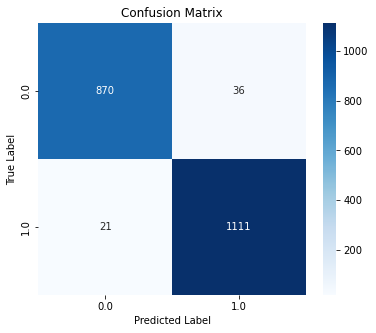

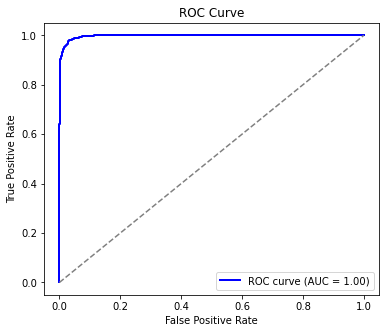

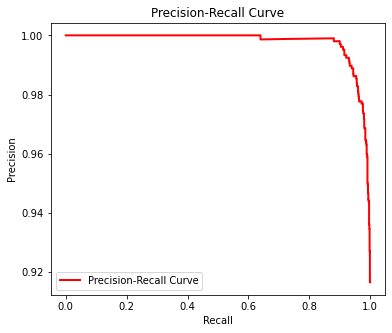

In [22]:
# Output the best parameters and the best score
logging.info("Best parameters: {}".format(grid_search.best_params_))
logging.info("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best parameters to fit the test set
model_best_svm = grid_search.best_estimator_
test_score = model_best_svm.score(X_test, y_test)
logging.info("Test set score: {:.2f}".format(test_score))

# Save best model
svm_model = os.path.join(config.save_results, "svm_model_" + formatted_time + ".pkl")
joblib.dump(model_best_svm, svm_model)
logging.info("Svm model has been saved to: {}".format(scale_model))

# Predict the test set
y_pred = model_best_svm.predict(X_test)

# Calculate accuracy, precision, recall, f1
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logging.info("Test set accuracy: {:.2f}".format(accuracy))
logging.info("Test set precision: {:.2f}".format(precision))
logging.info("Test set recall: {:.2f}".format(recall))
logging.info("Test set f1: {:.2f}".format(f1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC and PR curves for binary classification
if len(set(y_test)) == 2:
    # y_prob = model_best_svm.predict_proba(X_test)[:, 1]  # Get probability for positive class
    y_prob = model_best_svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="red", lw=2, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()

# Using a sliding window mechanism to traverse different sized images, extract HOG features from the current window, calculate distances using the SVM model, and filter out redundant boxes through NMS.

In [10]:
# Sliding window
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Pyramid
def pyramid(image, scale, min_size):
    yield image
    while image.shape[0] > min_size[1] and image.shape[1] > min_size[0]:
        image = cv2.resize(image, 
                           (int(image.shape[1] / scale), int(image.shape[0] / scale)), 
                           interpolation=cv2.INTER_LINEAR)
        yield image

# Non-maximum suppression
def apply_nms(detections, overlap_thresh):
    rects = np.array(detections)
    return non_max_suppression(rects, probs=None, overlapThresh=overlap_thresh)

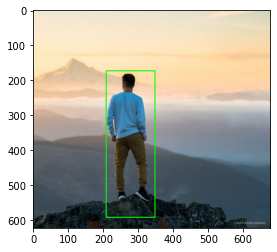

In [ ]:
# Sliding window detection
def detect(image, svm, scaler, window_size, step_size, scale, min_size, dis_thre):
    detections = []
    for resized_image in pyramid(image, scale, min_size):
        # Calculate the scaling factor for the current pyramid layer
        scale_factor = image.shape[0] / float(resized_image.shape[0])  
        for (x, y, window) in sliding_window(resized_image, step_size, window_size):
            if window.shape[:2] != (window_size[1], window_size[0]):
                continue
            # Extract HOG features, using default hog parameters
            features = hog(window, 
                           orientations = config.orientations,
                            pixels_per_cell = config.pixels_per_cell,
                            cells_per_block = config.cells_per_block,
                            block_norm = config.block_norm,
                            transform_sqrt = config.transform_sqrt,
                            feature_vector = config.feature_vector)
            features = scaler.transform([features])
            # SVM calculates the distance of the test sample to the decision plane
            dis = svm.decision_function(features)
            if dis > dis_thre:
                detections.append((int(x * scale_factor), int(y * scale_factor), 
                                    int((x + window_size[0]) * scale_factor), int((y + window_size[1]) * scale_factor)))
    return detections

# Test process
imgp = config.test_files
image_bgr = cv2.imread(imgp)
image_gray = cv2.cvtColor(image_bgr.copy(), cv2.COLOR_BGR2GRAY)
Scaler = joblib.load(os.path.join(config.load_models, "scale_model_2025_02_11_14_07_47.pkl"))
SVM_model = joblib.load(os.path.join(config.load_models, "svm_model_2025_02_11_14_07_47.pkl"))

detections = detect(image_gray, SVM_model, Scaler, config.window_size, config.step_size, config.scale, config.min_size, config.dis_thre)
final_detections = apply_nms(detections, config.nms_threshold)

for (x, y, x_end, y_end) in final_detections:
    cv2.rectangle(image_bgr, (x, y), (x_end, y_end), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Multi-threaded detection

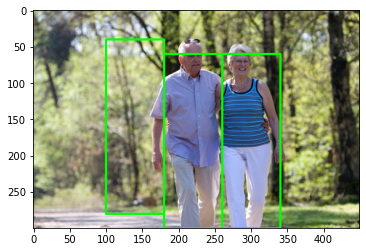

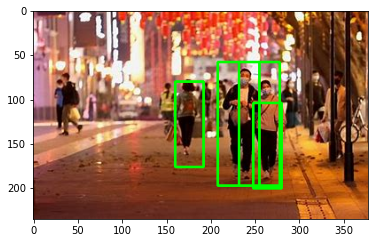

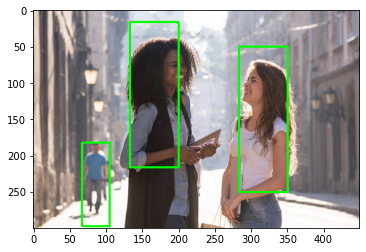

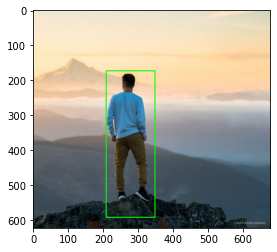

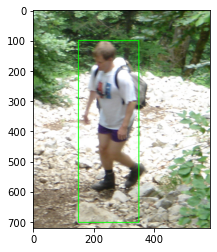

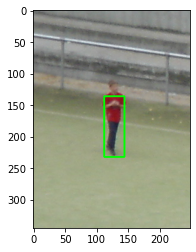

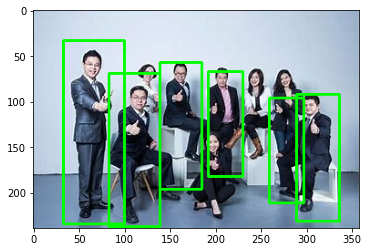

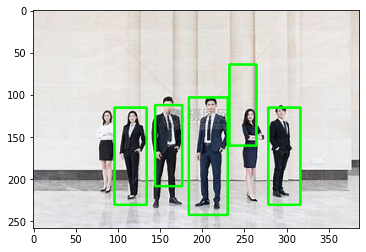

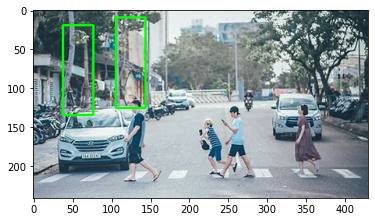

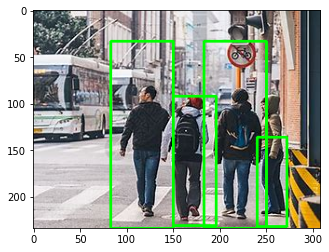

In [ ]:
# Process a single window
def process_window(x, y, window, scale_factor, svm, scaler, window_size, dis_thre):
    """ Process a single sliding window, calculate HOG + SVM confidence """
    if window.shape[:2] != (window_size[1], window_size[0]):
        return None
    # Calculate HOG features
    features = hog(window,
                   orientations = config.orientations,
                    pixels_per_cell = config.pixels_per_cell,
                    cells_per_block = config.cells_per_block,
                    block_norm = config.block_norm,
                    transform_sqrt = config.transform_sqrt,
                    feature_vector = config.feature_vector)
    features = scaler.transform([features])
    # SVM distance calculation
    dis = svm.decision_function(features)
    if dis > dis_thre:
        return (int(x * scale_factor), int(y * scale_factor), 
                int((x + window_size[0]) * scale_factor), int((y + window_size[1]) * scale_factor))
    return None

# Multi-threaded sliding window detection
def detect(image, svm, scaler, window_size, step_size, scale, min_size, dis_thre, workers):
    detections = []
    with ThreadPoolExecutor(max_workers = workers) as executor:
        future_tasks = []
        for resized_image in pyramid(image, scale, min_size):
            scale_factor = image.shape[0] / float(resized_image.shape[0])
            # **Submit tasks in batches**
            for (x, y, window) in sliding_window(resized_image, step_size, window_size):
                future = executor.submit(process_window, x, y, window, scale_factor, 
                                         svm, scaler, window_size, dis_thre)
                future_tasks.append(future)
        # **Parallel retrieval of results**
        for future in as_completed(future_tasks):
            result = future.result()
            if result:
                detections.append(result)

    return detections

# Test process
Scaler = joblib.load(os.path.join(config.load_models, "scale_model_2025_02_11_14_07_47.pkl"))
SVM_model = joblib.load(os.path.join(config.load_models, "svm_model_2025_02_11_14_07_47.pkl"))

imgp = config.test_files
if os.path.isdir(imgp):
    for it in os.listdir(imgp):
        image_bgr = cv2.imread(os.path.join(imgp, it))
        image_gray = cv2.cvtColor(image_bgr.copy(), cv2.COLOR_BGR2GRAY)
        detections = detect(image_gray, SVM_model, Scaler, config.window_size, 
                            config.step_size, config.scale, config.min_size, config.dis_thre, config.max_workers)
        final_detections = apply_nms(detections, config.nms_threshold)
        for (x, y, x_end, y_end) in final_detections:
            cv2.rectangle(image_bgr, (x, y), (x_end, y_end), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.show()